<a href="https://www.kaggle.com/code/thikhuyenle/stock-price-prediction-using-lstm?scriptVersionId=118028673" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Use LSTM to predict the closing stock price of a corporation in a sequence of datasets (Stocks)**

### Table of content

1. [Data preparation](#Data_preparation)
2. [Visualization](#visualization)
3. [Data preprocessing](#data_preprocessing)
4. [Build LSTM model](#build_LSTM)
5. [Model evaluation](#model_evaluation)

<a name="data_preparation"></a>
### 1. Data preparation

In [1]:
import os
import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

data_path = '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/'
print('Data folders: ', os.listdir(data_path))

print('Number of files in Stocks: ', len(os.listdir(data_path + 'Stocks/')))
print('Number of files in ETFs: ', len(os.listdir(data_path + 'ETFs/')))

2023-02-02 13:09:12.055669: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-02 13:09:12.055827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Data folders:  ['Stocks', 'ETFs', 'Data']
Number of files in Stocks:  7195
Number of files in ETFs:  1344


In [2]:
# select the first dataset in Stocks
stock_path = data_path + 'Stocks/'
data_name = os.listdir(stock_path)[0]
print('Name of selected dataset:', data_name)

# read the dataset
df = pd.read_csv(stock_path + data_name)
# Set the "Date" column as index
#df = df.set_index('Date')

Name of selected dataset: ufi.us.txt


<a name = "visualization"></a>
### 2. Visualization

Text(0.5, 1.0, 'Price history')

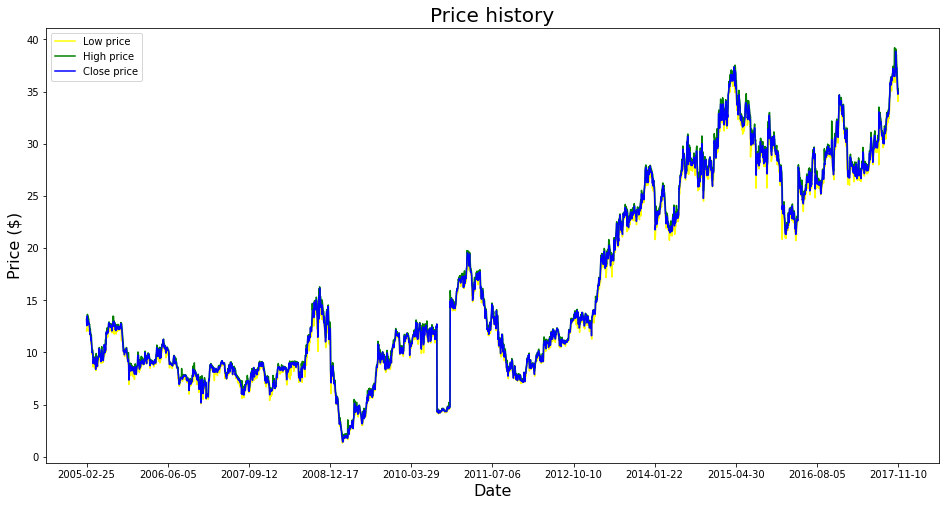

In [3]:
N = df.shape[0]
plt.figure(figsize = (16,8))
plt.plot(df['Low'], color = 'yellow', label = 'Low price')
plt.plot(df['High'], color = 'green', label = 'High price')
plt.plot(df['Close'], color = 'blue', label = 'Close price')
plt.xticks(np.arange(0, N +1, np.int(N/10)), df['Date'][0:N:np.int(N/10)])
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Price ($)', fontsize = 16)
plt.legend()
plt.title('Price history', fontsize = 20)

### 3. Data preprocessing

**Splitting train/test sets**

In [4]:
# select column "Close" as the sample 
data = df['Close'].values
# Separate data into two sets: one set (80%) for training and the other (20%) for testing the model
L = math.ceil(len(data)*0.8)
data_train = data[:L]
data_test = data[L:]

print('Train:', len(data_train))
print('Test:', len(data_test))

Train: 2561
Test: 640


**Data normalization**

In [5]:
scaler = MinMaxScaler(feature_range = (0,1))

data_train_scaled = scaler.fit_transform(data_train.reshape(-1,1))
data_test_scaled = scaler.transform(data_test.reshape(-1,1))

In [6]:
# Separate data_train_scaled into train and validation sets 
len_train = math.ceil(len(data_train_scaled)*0.8)

X_train = []
y_train = []

for i in range(40, len_train):
    X_train.append(data_train_scaled[(i-40):i,0])
    y_train.append(data_train_scaled[i,0])

# convert X_train, y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(2009, 40, 1)


In [7]:
X_val = []
y_val = []

for i in range(len_train, len(data_train_scaled)):
    X_val.append(data_train_scaled[(i-40):i,0])
    y_val.append(data_train_scaled[i,0])
    
X_val, y_val = np.array(X_val), np.array(y_val)

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
print(X_val.shape)

(512, 40, 1)


In [8]:
df_train = df[:len_train]
df_val = df[len_train:len(data_train_scaled)]

## 4. Build the LSTM model

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

# compile themodel
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

2023-02-02 13:09:18.218475: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-02 13:09:18.221226: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-02 13:09:18.221273: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 13:09:18.221308: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fc1cf4666fe8): /proc/driver/nvidia/version does not exist
2023-02-02 13:09:18.222739: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [10]:
# Train the model
H = model.fit(X_train, y_train, batch_size = 10, epochs = 80)

2023-02-02 13:09:19.175087: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-02 13:09:19.185912: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/80
201/201 [==============================] - 10s 35ms/step - loss: 0.0062
Epoch 2/80
201/201 [==============================] - 7s 34ms/step - loss: 7.4819e-04
Epoch 3/80
201/201 [==============================] - 7s 33ms/step - loss: 5.7742e-04
Epoch 4/80
201/201 [==============================] - 7s 34ms/step - loss: 3.9203e-04
Epoch 5/80
201/201 [==============================] - 7s 35ms/step - loss: 4.2952e-04
Epoch 6/80
201/201 [==============================] - 7s 34ms/step - loss: 3.6586e-04
Epoch 7/80
201/201 [==============================] - 7s 34ms/step - loss: 2.9134e-04
Epoch 8/80
201/201 [==============================] - 7s 35ms/step - loss: 3.0396e-04
Epoch 9/80
201/201 [==============================] - 7s 35ms/step - loss: 2.6002e-04
Epoch 10/80
201/201 [==============================] - 7s 35ms/step - loss: 3.5446e-04
Epoch 11/80
201/201 [==============================] - 7s 34ms/step - loss: 1.8194e-04
Epoch 12/80
201/201 [==============================] - 

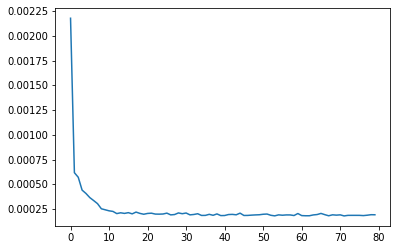

In [11]:
plt.plot(H.history['loss'])

## 5. Evaluate the model

**5.1. Evaluation on the validation set**

In [12]:
y_val_pred = model.predict(X_val)
y_val_pred = scaler.inverse_transform(y_val_pred.reshape(-1,1))

y_val_true = scaler.inverse_transform(y_val.reshape(-1,1))
# compute the root mean squared error (RMSE)
error = np.sqrt(np.mean(y_val_pred - y_val_true)**2)
print(error)

0.27704431757330894


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


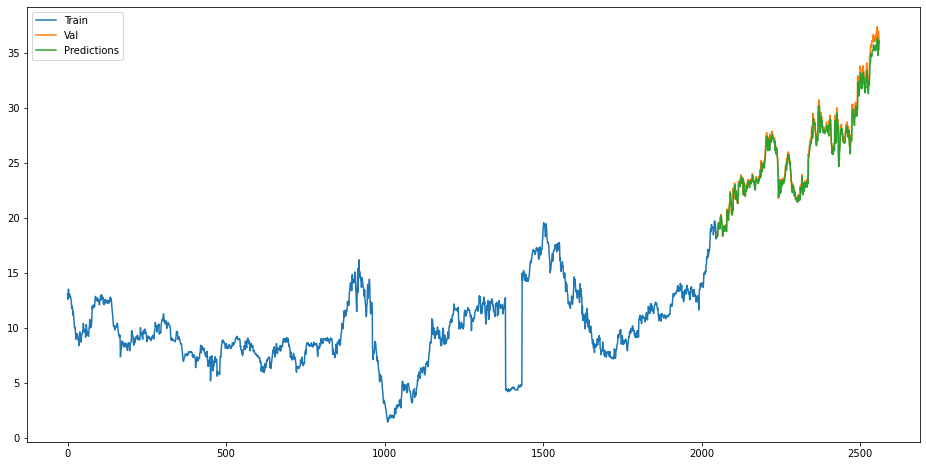

In [13]:
df_val['predictions'] = y_val_pred

plt.figure(figsize = (16,8))

plt.plot(df_train['Close'])
plt.plot(df_val[['Close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'])

**5.2. Evaluation on the test set**

In [14]:
# Evaluate the model on the test set

X_test = []
y_test = []
data_test 

for i in range(40, len(data_test_scaled)):
    X_test.append(data_test_scaled[(i-40):i, 0])
    y_test.append(data_test_scaled[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)
                    

(600, 40, 1)


In [15]:
y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_true = scaler.inverse_transform(y_test.reshape(-1,1))

test_error = np.sqrt(np.mean(y_test_true - y_test_pred)**2)
print(test_error)

0.3388890206654866


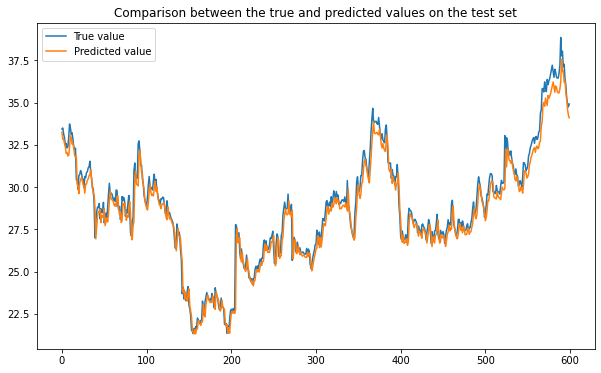

In [16]:
plt.figure(figsize = (10,6))
plt.plot(y_test_true, label = 'True value')
plt.plot(y_test_pred, label = 'Predicted value')
plt.legend()
plt.title('Comparison between the true and predicted values on the test set')
plt.show()